In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Triazines

In [2]:
from sklearn.datasets import fetch_openml

# Triazines dataset from UCI
triazines = fetch_openml(name='triazines', version=1, as_frame=True)
X = triazines.data
y = triazines.target

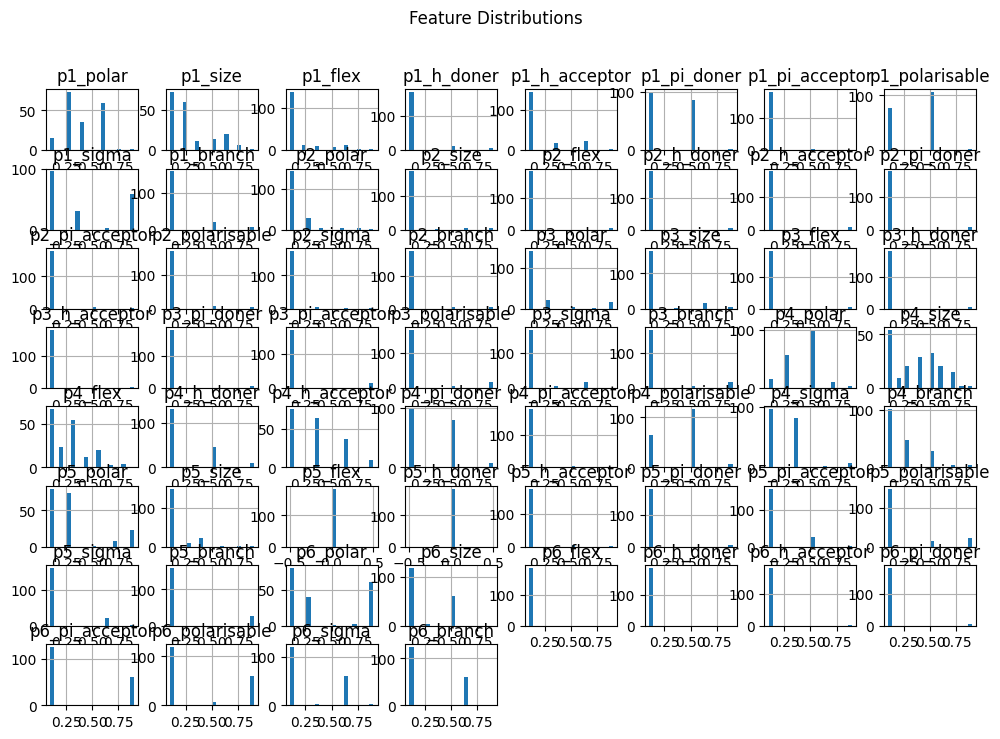

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

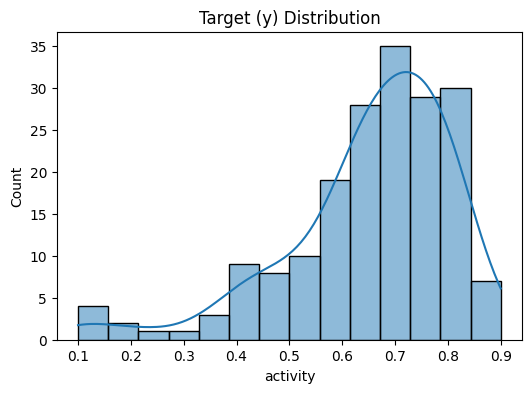

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

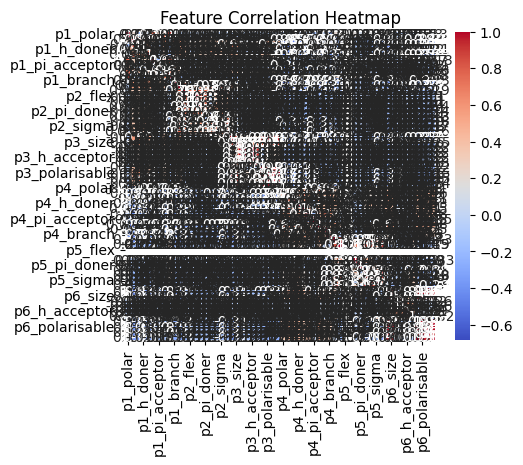

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
ndpost=1000
nskip=1000
n_trees=5

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=ndpost, nskip=nskip, n_trees=n_trees, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.135723                 1.099196             1.256891   
1                  1.101525                 1.378047             1.126669   
2                  1.334746                 1.313610             1.164139   
3                  1.205041                 1.415717             1.092110   
4                  1.179985                 1.233463             1.198901   
5                  1.102117                 1.074413             1.369533   
6                  1.089821                 1.323880             1.232316   
7                  1.016741                 1.294285             1.273934   
8                  1.417665                 1.166497             1.063120   
9                  1.030378                 1.085091             1.074231   
mean               1.161374                 1.238420             1.185184   
std                0.128645              

In [9]:
rhat_df.to_csv("results/real8_Triazines_rhat.csv", index=False)

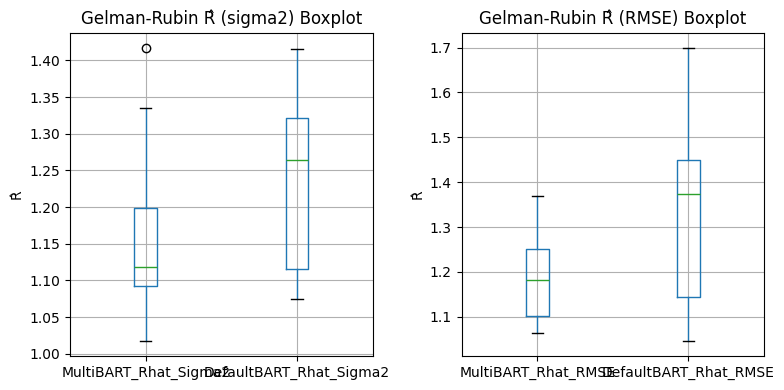

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-10-08 03:26:55,966:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-08 03:26:56,154:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-08 03:26:56,270:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.021533  0.023550  0.019953  0.017765  0.020037
1      0.008964  0.013147  0.012969  0.013207  0.011040
2      0.018015  0.016995  0.021941  0.018752  0.016782
3      0.022868  0.020984  0.016184  0.020066  0.022594
4      0.016265  0.019180  0.016407  0.028915  0.015331
5      0.020155  0.022388  0.018009  0.030925  0.028538
6      0.019155  0.019261  0.019564  0.020768  0.017449
7      0.016890  0.020481  0.018308  0.019770  0.017471
8      0.007659  0.006564  0.007031  0.009195  0.006791
9      0.011309  0.012880  0.012892  0.010742  0.010322
mean   0.016281  0.017543  0.016326  0.019010  0.016636
std    0.005273  0.005245  0.004364  0.007031  0.006324



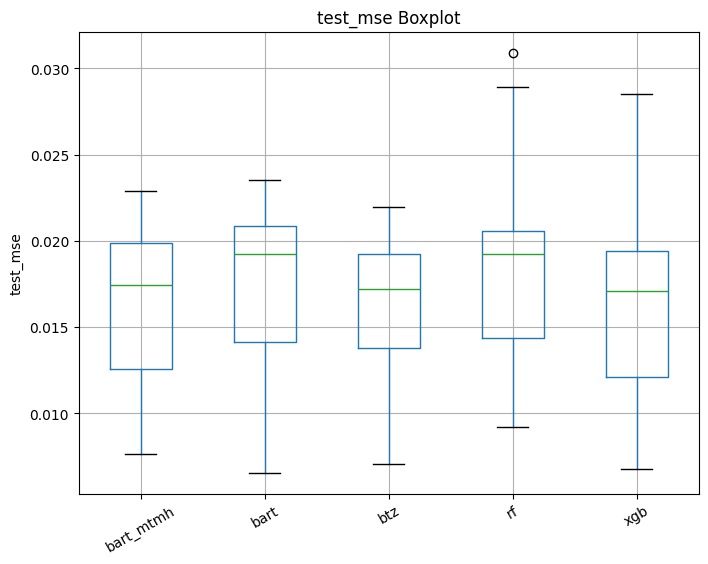

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.005323  0.007028  0.008650  0.003333  0.004107
1      0.009098  0.012310  0.013330  0.004024  0.005159
2      0.009246  0.007318  0.012946  0.003879  0.004381
3      0.005877  0.006439  0.009840  0.003780  0.003794
4      0.007190  0.007224  0.013190  0.004650  0.004876
5      0.005880  0.006692  0.011258  0.003900  0.004678
6      0.007790  0.006985  0.010717  0.003305  0.003864
7      0.008060  0.010619  0.010815  0.003547  0.004989
8      0.012392  0.010488  0.014075  0.003921  0.008216
9      0.009925  0.009966  0.014705  0.003985  0.006785
mean   0.008078  0.008507  0.011953  0.003832  0.005085
std    0.002175  0.002111  0.001977  0.000388  0.001396



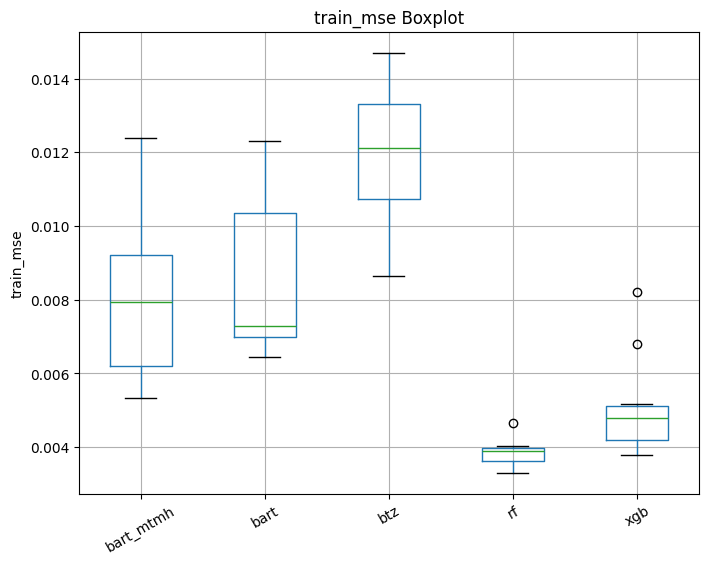

pi_length:
      bart_mtmh      bart       btz
0      0.370359  0.412829  0.439602
1      0.478482  0.530654  0.544178
2      0.481740  0.445263  0.521402
3      0.368093  0.374530  0.478808
4      0.447639  0.402408  0.578232
5      0.367882  0.383829  0.523763
6      0.423864  0.423336  0.538875
7      0.450560  0.486061  0.524536
8      0.543952  0.505209  0.565488
9      0.504248  0.486357  0.561642
mean   0.443682  0.445048  0.527653
std    0.061167  0.054144  0.041829



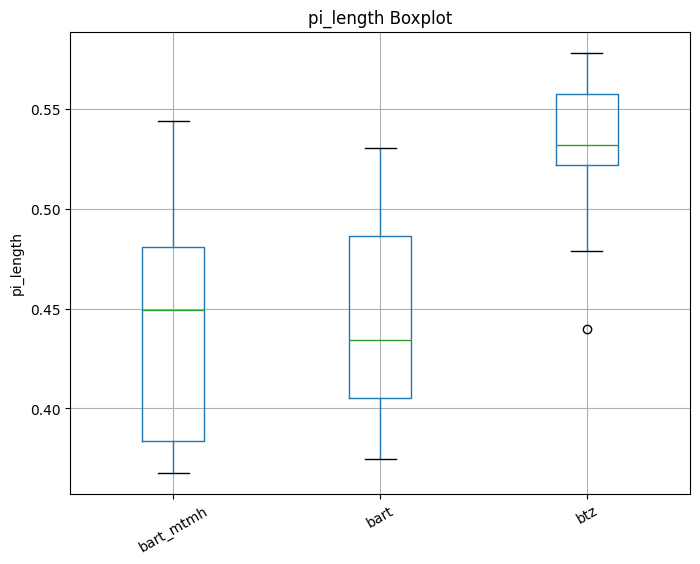

coverage:
      bart_mtmh      bart       btz
0      0.851064  0.872340  0.893617
1      1.000000  1.000000  0.978723
2      0.957447  0.957447  0.957447
3      0.829787  0.872340  0.957447
4      0.936170  0.914894  0.978723
5      0.872340  0.829787  0.936170
6      0.914894  0.893617  0.957447
7      0.914894  0.893617  0.893617
8      1.000000  1.000000  1.000000
9      0.957447  0.957447  0.978723
mean   0.923404  0.919149  0.953191
std    0.058656  0.057442  0.035884



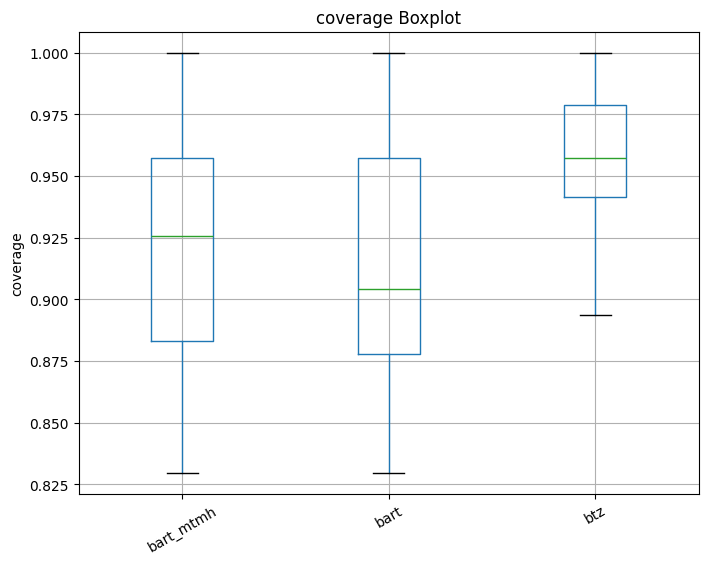

train_time:
      bart_mtmh      bart       btz        rf       xgb
0      4.361123  0.967813  7.806197  0.015370  0.041469
1      4.158686  0.863099  8.605881  0.017174  0.046376
2      4.137743  0.883322  8.540848  0.015080  0.042464
3      4.018167  0.847485  7.741543  0.013507  0.042449
4      4.329098  0.882886  7.865566  0.012028  0.041975
5      5.436537  0.924387  8.133372  0.015302  0.042492
6      4.081265  0.880115  7.600723  0.013319  0.035555
7      4.423673  0.846143  8.904406  0.015196  0.043852
8      4.092628  0.842044  8.548469  0.019498  0.059293
9      4.011495  0.821711  8.727842  0.014916  0.045309
mean   4.305042  0.875901  8.247485  0.015139  0.044123
std    0.423103  0.043282  0.470849  0.002080  0.006055



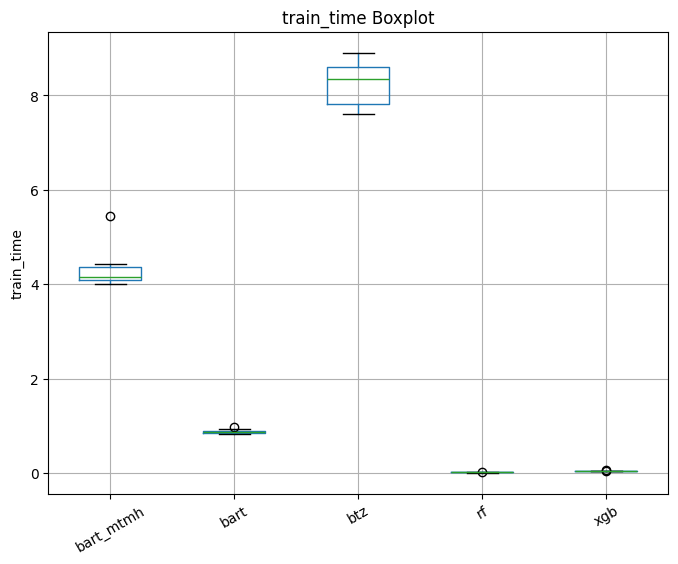

In [11]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=nskip, n_post=ndpost, n_trees=n_trees, n_jobs=-2)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [12]:
for k, v in mse_results.items():
    csv_name = f"results/real8_Triazines_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [13]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real8_Triazines_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=10, n_chains=4,
    ndpost=ndpost, nskip=nskip, n_trees=n_trees, n_jobs=-2
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real8_Triazines_tries.csv", index=False)

In [14]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.248569   1.436590  0.018992  0.925532    2.554735
1            5     1.252922   1.297879  0.016068  0.938298    3.216179
2           10     1.161374   1.185184  0.016945  0.917021    4.191131
3           50     1.167279   1.154093  0.015831  0.931915   12.950867
4          100     1.132535   1.139357  0.016632  0.931915   25.795957
